In [1]:
# load packages
import numpy as np 
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
from itertools import chain
from scipy.optimize import curve_fit

#### Set directory and import files

In [2]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\SSRP_analysis_branch\\Contrast_Response_Functions\\' # set dir - on my computer
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Avilable Files to choose from: {len(d)}')
print(f'Files on hand: {d}')
##############################################
FileN_f1 = d[2] #  data    
print(FileN_f1) 
file_path1 = os.path.join(MainDir, FileN_f1) # join paths and prep 2 load
print( 'Group Imported:', file_path1.split('_')[-5], file_path1.split('_')[-4])
loadData = pkl.load(open(file_path1, 'rb'))
print('Keys Avilable:', loadData.keys())

Avilable Files to choose from: 4
Files on hand: ['SSRP_CntrlGroup_RCA1_CRF_20240627_150221.pkl', 'SSRP_CntrlGroup_RCA2_CRF_20240627_150307.pkl', 'SSRP_ExptGroup_RCA1_CRF_20240627_145808.pkl', 'SSRP_ExptGroup_RCA2_CRF_20240627_150025.pkl']
SSRP_ExptGroup_RCA1_CRF_20240627_145808.pkl
Group Imported: ExptGroup RCA1
Keys Avilable: dict_keys(['F1_Norm_CRF', 'F2_Norm_CRF', 'F1_Diffs', 'F2_Diffs', 'F1_CRF', 'F2_CRF', 'F1_Raw_Diffs', 'F2_Raw_Diffs', 'File_Location_Indicies', 'Subj_Num_Ids'])


In [3]:
Group = file_path1.split('_')[-5]
RCAComp = file_path1.split('_')[-4]
FileOutName = f'Subject_ANOVA_DF_{Group}_{RCAComp}_2F_HarmonicOnly_STD_3_5' # pre post in a single col 
# FileOutName = f'Subject_ANOVA_DF_{Group}_{RCAComp}_prepostCols_2F4F' # with pre post as seperate cols
print(FileOutName)

Subject_ANOVA_DF_ExptGroup_RCA1_2F_HarmonicOnly_STD_3_5


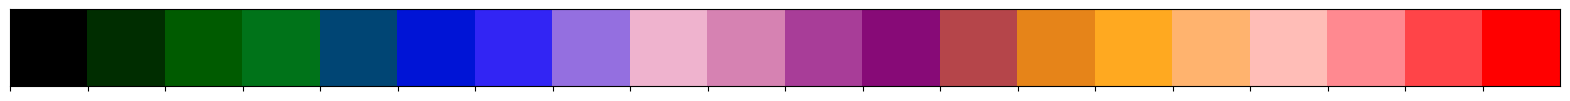

In [4]:
# Define the base colors for blending
base_colors = ['black','green', 'blue', 'pink' ,'purple', 'orange', 'pink','red']
# Number of colors in the spectrum
num_colors = 20
fill = sns.blend_palette(base_colors, n_colors=num_colors, as_cmap=False)
sns.palplot(fill)
plt.show()
color_set = [11,1,8,4]

contrast_labs = ['1%','3%','5%','16%','40%','100%']
color_set = [3,6,12,13]

custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)

## *Import Data from pkl file*

In [5]:
# subject names and arrays to index attnL and attnR expts
File_Pos = loadData['File_Location_Indicies']
Subj_Ids = loadData['Subj_Num_Ids']

### **Import Normalized Data**

In [6]:
## clean pre post CRF's
F1_Responses = loadData['F1_Norm_CRF']
F2_Responses = loadData['F2_Norm_CRF']
# post - pre crf response for normalized contrasts
F1_Diffs = loadData['F1_Diffs']
F2_Diffs = loadData['F2_Diffs']

### Sanity Check to make sure normalized data and original data are the same

[ 0.10707802  0.03621729  0.0074908   0.19590309 -0.05165753 -0.16439054]


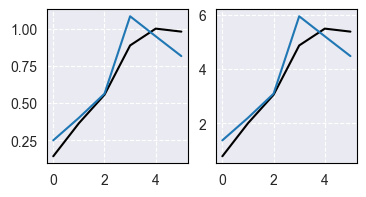

In [7]:
F1_Responses_normz = loadData['F1_Norm_CRF']
F1_Responses_orig = loadData['F1_CRF']

subject_ex = 7
f1_n = F1_Responses_normz[subject_ex][0,:,:]
f1_o  = F1_Responses_orig[subject_ex][0,:,:]

fig,axs = plt.subplots(1,2,figsize= ((4,2)))

axs[0].plot(f1_n[0,:], color = 'black')
axs[0].plot(f1_n[1,:])

axs[1].plot(f1_o[0,:], color = 'black')
axs[1].plot(f1_o[1,:])

print(f1_n[1,:] - f1_n[0,:])

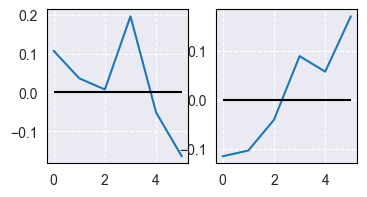

In [8]:
# and diffs ...
F1_Diffs_n = loadData['F1_Diffs']
F1_Diffs_o = loadData['F2_Raw_Diffs'] 

diff_n = F1_Diffs_n[subject_ex][0,:]
diff_o = F1_Diffs_o[subject_ex][0,:]

fig,axs = plt.subplots(1,2,figsize= ((4,2)))

axs[0].plot(diff_n)
axs[0].hlines(0,xmin = 0,xmax = 5, color = 'black')
axs[1].plot(diff_o)
axs[1].hlines(0,xmin = 0,xmax = 5, color = 'black')

### Import Raw Data just in case 

In [9]:
# #orignal contrast response functions 
# F1_Responses = loadData['F1_CRF']
# F2_Responses = loadData['F2_CRF']
# # post-  pre / pre + post
# F1_Diffs = loadData['F2_Raw_Diffs'] 
# F2_Diffs = loadData['F1_Raw_Diffs']

#### Plot Session CRF and Response Differences per subject

In [10]:
crf_nans = np.zeros((4,2,6))
diff_nans = np.zeros((4,6))
crf_nans[:] = np.nan
diff_nans[:] = np.nan

CRF_IndividualResponses_Sorted = []
PostInduction_IndividualResponses_Sorted = []

#### *Seperate Data From AttnL and AttnR based on Experiment File Name*

#### **First 2 sets belong to Spatial Deployment LEFT, Last 2 sets belong to Spatial Deployment RIGHT**
### *Based on the indexing performed below, conditions are sorted as:*
##### *Attention Induction Congruent, Attention Induction Incongruent*
### [Potentiated - Attention Congruent, Non-Potentiated-Attention Congruent, Potentiated - Attention Incongruent , Non-Potentiated - Attention Incongruent]

In [11]:
for iter in range(len(Subj_Ids)):

    Subj_Title = Subj_Ids[iter] # subject 
    Indiv_File_Locations = File_Pos[iter,:] # import file locations for data

    AttendL_Condition = Indiv_File_Locations[0] # attnL file
    AttendR_Condition = Indiv_File_Locations[1] # attnR file

    # If both locations contain NaNs, replace all data
    if np.isnan(AttendL_Condition) and np.isnan(AttendR_Condition):
        CRF_Set = [crf_nans, crf_nans, crf_nans, crf_nans]
        Diff_Set = [diff_nans, diff_nans, diff_nans, diff_nans]
        print('Both AttnL and AttnR files are missing, now replacing all data ...')
        print(Indiv_File_Locations)
    # If the first position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendL_Condition):
        print('Attn L file is missing, now replacing ...')
        print(Indiv_File_Locations)
        CRF_Set = [crf_nans, crf_nans, F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
        Diff_Set = [diff_nans, diff_nans, F1_Diffs[int(AttendR_Condition)], F2_Diffs[int(AttendR_Condition)]]
    # If the second position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendR_Condition):
        print('Attn R file is missing, now replacing ...')
        print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], crf_nans, crf_nans]
        Diff_Set = [F1_Diffs[int(AttendL_Condition)], F2_Diffs[int(AttendL_Condition)], diff_nans, diff_nans]
    else:
        print('Both AttnL and AttnR files are present.')
        print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
        Diff_Set = [F1_Diffs[int(AttendL_Condition)], F2_Diffs[int(AttendL_Condition)], F1_Diffs[int(AttendR_Condition)], F2_Diffs[int(AttendR_Condition)]]
        # Continue with dividing data conditions as necessary
        
    CRF_IndividualResponses_Sorted.append(CRF_Set)
    PostInduction_IndividualResponses_Sorted.append(Diff_Set)

Both AttnL and AttnR files are present.
[0. 1.]
Both AttnL and AttnR files are present.
[2. 3.]
Both AttnL and AttnR files are present.
[4. 5.]
Both AttnL and AttnR files are present.
[6. 7.]
Both AttnL and AttnR files are present.
[8. 9.]
Both AttnL and AttnR files are present.
[10. 11.]
Both AttnL and AttnR files are present.
[12. 13.]
Both AttnL and AttnR files are present.
[14. 15.]
Attn R file is missing, now replacing ...
[16. nan]
Both AttnL and AttnR files are present.
[17. 18.]
Both AttnL and AttnR files are missing, now replacing all data ...
[nan nan]
Both AttnL and AttnR files are present.
[21. 22.]
Both AttnL and AttnR files are present.
[23. 24.]
Both AttnL and AttnR files are present.
[25. 26.]
Both AttnL and AttnR files are present.
[27. 28.]
Both AttnL and AttnR files are present.
[29. 30.]
Both AttnL and AttnR files are present.
[31. 32.]
Both AttnL and AttnR files are present.
[33. 34.]
Both AttnL and AttnR files are present.
[35. 36.]
Both AttnL and AttnR files are 

38
4
(4, 6)


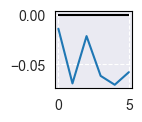

In [12]:
print(len(PostInduction_IndividualResponses_Sorted))
print(len(PostInduction_IndividualResponses_Sorted[0]))
# subject ID, condition 1-4 and [4x6] represents response difference per harmonic across contrasts
print(PostInduction_IndividualResponses_Sorted[0][0].shape)
fig,axs = plt.subplots(figsize = (1,1))
plt.plot(PostInduction_IndividualResponses_Sorted[0][0][0,:])
plt.hlines(0,xmin = 0,xmax = 5, color = 'black')

In [13]:
def CombineResponses(DataIn, Cond2Import, HarmonicIndex):
    # combine data sets in terms of attention and hemifield, sorting ONLY
    Rows = int(len(DataIn))
    Data_Diffs_Mat = np.zeros((Rows,6)) # numsubs x contrasts 
    for combine in range(len(DataIn)):
        Data_Diffs_Mat[combine,:] = DataIn[combine][Cond2Import][HarmonicIndex,:]
    return Data_Diffs_Mat

#### *Enter Harmonic of Interest to visualize results, 0=2F, 1=4F, 2=6F, 3=8F*

In [14]:
Condition_Label = ['Potentiated, A+', 'Non-Pot, A+', 'Potentiated, A-', 'Non-Potentiated, A-']
ConditionData = {}
for CondX in range(4):

    ConditionData[CondX] = CombineResponses(DataIn = PostInduction_IndividualResponses_Sorted, Cond2Import = CondX, HarmonicIndex = 0)
    print(ConditionData[CondX].shape)

(38, 6)
(38, 6)
(38, 6)
(38, 6)


bas subjs: 9
bas subjs: 13
bas subjs: 18
bas subjs: 36
bas subjs: 23
bas subjs: 18


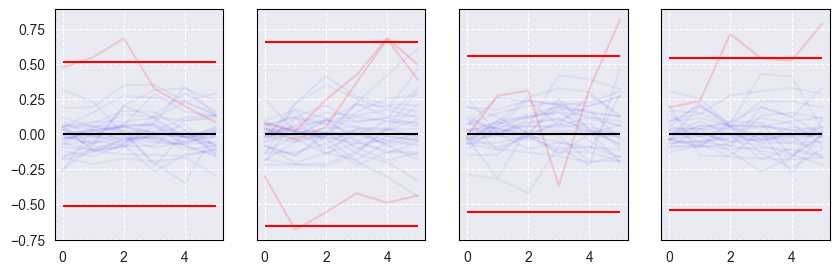

In [15]:
fig,axs = plt.subplots(1,4, figsize = ((10,3)), sharey = True)

DubSubs = []
for CondX in range(4):
    pltData = np.array(ConditionData[CondX])
    avgDiff = np.nanmean(pltData,axis = 0) # get average 
    # avgMedian = np.nanmedian(pltData,axis = 0)
    avgSTD = np.nanstd(pltData, axis = (0,1))
    #print(avgSTD)
    stdThresh = 3.5
    axs[CondX].hlines(avgSTD*stdThresh, xmin = 0,xmax = 5,color = 'red')
    axs[CondX].hlines(avgSTD*-stdThresh, xmin = 0,xmax = 5,color = 'red')
    # plt.vlines()

    for subs in range((pltData.shape[0])):
        crf_data = pltData[subs,:]
        if np.any(avgSTD*stdThresh < crf_data) or np.any(avgSTD*-stdThresh > crf_data):
            print(f'bas subjs: {subs}')
            DubSubs.append(subs)
            axs[CondX].plot(pltData[subs,:], color = 'red', alpha = 0.15)
        else:
            axs[CondX].plot(pltData[subs,:], color = 'blue', alpha = 0.05)

    axs[CondX].hlines(0, xmin = 0,xmax = 5,color = 'black')

In [16]:
DubSubs = np.array(np.unique(DubSubs))
print(DubSubs)

[ 9 13 18 23 36]


### Based on visual inspection of response changes post inducton, select dubious subject performance and plot across all sessions

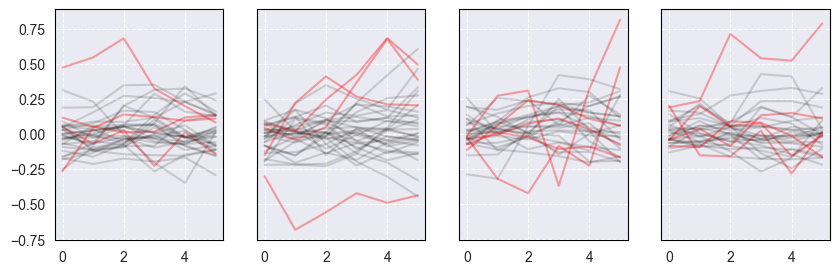

In [17]:
fig,axs = plt.subplots(1,4, figsize = ((10,3)), sharey = True)
for CondX in range(4):
    pltData = np.array(ConditionData[CondX])
    # avgDiff = np.nanmean(pltData,axis = 0) # get average 
    # avgMedian = np.nanmedian(pltData,axis = 0)
    # avgSTD = np.nanstd(pltData, axis = 0)

    for subs in range((pltData.shape[0])):
        if subs in DubSubs:
            #print()
            axs[CondX].plot(pltData[subs,:], color = 'red', alpha = 0.35)
        else:
            axs[CondX].plot(pltData[subs,:], color = 'black', alpha = 0.15)

        
    # axs[CondX].plot(avgDiff, color = fill[11], linewidth = 4, label = 'mean')
    # axs[CondX].plot(avgMedian, color = fill[12], linewidth = 4, label = 'median')
    
#     axs[CondX].hlines(0,xmin = 0 ,xmax = 5, color = 'black', linewidth =2)
#     #axs.legend()
#     axs[CondX].set_ylabel(f'Amplitude (mV)')
#     axs[CondX].set_xlabel(f'Contrast %')
#     axs[CondX].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
# axs[3].legend()

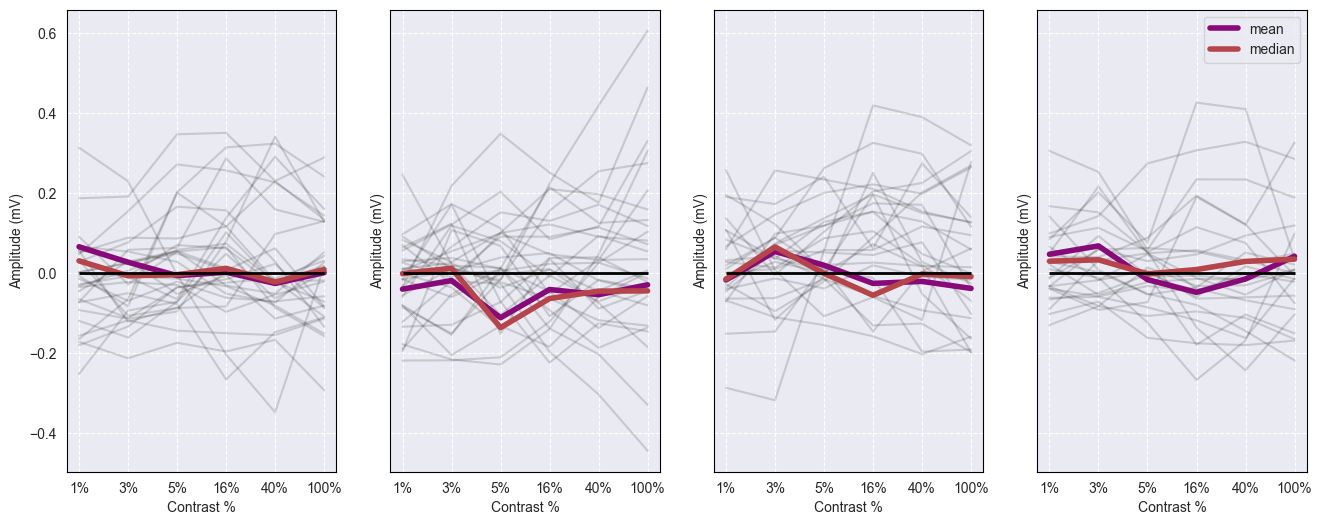

In [18]:
fig,axs = plt.subplots(1,4, figsize = ((16,6)), sharey = True)

for CondX in range(4):
    pltData = ConditionData[CondX]
    avgDiff = np.nanmean(pltData[~DubSubs],axis = 0) # get average 
    avgMedian = np.nanmedian(pltData[~DubSubs],axis = 0)

    avgSTD = np.nanstd(pltData[~DubSubs], axis = 0)

    for subs in range((pltData.shape[0])):
        if subs not in DubSubs:
            axs[CondX].plot(pltData[subs,:], color = 'black', alpha = 0.15)
        
    axs[CondX].plot(avgDiff, color = fill[11], linewidth = 4, label = 'mean')
    axs[CondX].plot(avgMedian, color = fill[12], linewidth = 4, label = 'median')
    
    axs[CondX].hlines(0,xmin = 0 ,xmax = 5, color = 'black', linewidth =2)

    axs[CondX].set_ylabel(f'Amplitude (mV)')
    axs[CondX].set_xlabel(f'Contrast %')
    axs[CondX].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
axs[3].legend()

In [19]:
# ConditionData[0] = Potentiated, Attn Congruent           \ ATTENTION DEPLOYED TO LEFT
# ConditionData[1] = Non-Potentiated, Attn Congruent       \ ATTENTION DEPLOYED TO LEFT
# ConditionData[2] = Potentited, Attn Incongruent          \ ATTENTION DEPLOYED TO RIGHT
# ConditionData[3] = Non-Potentiated, Attn Incongruent     \ ATTENTION DEPLOYED TO RIGHT

In [20]:
GoodSubjs = np.ones((int(ConditionData[0].shape[0])))

for gs in range(len(GoodSubjs)):
    if gs in DubSubs:
        print(gs)
        GoodSubjs[gs] = 0
print(GoodSubjs)

9
13
18
23
36
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]


In [21]:
AvgCondX = {}
CondX_ErrorBars = {}

for CondX in range(4): # 4
    # get number of subjects (Number of observations)
    dataMat = np.array(ConditionData[CondX])
    dataIn = dataMat[GoodSubjs == 1,:]
    print(dataIn.shape)

    NumSubs = np.count_nonzero(~np.isnan(dataIn[:,0]))
    NumObservations = np.sqrt(NumSubs) 
    print(NumSubs, NumObservations)

    AvgCondX[CondX] = np.nanmean(dataIn,axis = 0) # average response
    # Standard dev / Number of obs (number of subjects)
    STDVals = (np.nanstd(dataIn,axis = 0))
    
    CondX_ErrorBars[CondX] = STDVals / NumObservations

(33, 6)
30 5.477225575051661
(33, 6)
30 5.477225575051661
(33, 6)
25 5.0
(33, 6)
25 5.0


#### Plot Responses Per [y/n]Potentiation and [+/-]Attn

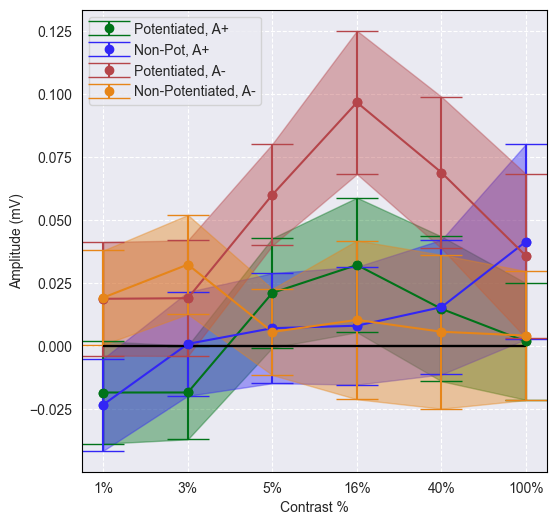

In [22]:
fig,axs = plt.subplots(figsize = ((6,6)))

for i in range(4):
    axs.plot(np.arange(0,6,1), AvgCondX[i],color = fill[color_set[i]],marker = 'o')
    axs.errorbar(np.arange(0,6,1),AvgCondX[i], yerr = CondX_ErrorBars[i], fmt = 'o',label = Condition_Label[i],color = fill[color_set[i]], barsabove= False , capsize=15)

    axs.fill_between(np.arange(0,6,1), AvgCondX[i] - CondX_ErrorBars[i], AvgCondX[i] + CondX_ErrorBars[i], color=fill[color_set[i]], alpha=0.4)

    axs.legend()
    axs.set_ylabel(f'Amplitude (mV)')
    axs.set_xlabel(f'Contrast %')
    axs.set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
    axs.hlines(0,xmin = 0,xmax = 5, color = 'black')

#### Plot Responses Per [y/n] Potentiation, no effect of attention

In [23]:
Potentiation_Group = np.concatenate((ConditionData[0],ConditionData[2]))
Non_Potentiation_Group = np.concatenate((ConditionData[1],ConditionData[3]))

In [24]:
Potentiation_DataSet = [Potentiation_Group,Non_Potentiation_Group]

In [25]:
Pot_DataSet_Avg = {}
Pot_DataSet_Med = {}
Pot_DataSet_Std = {}

for group in range(2):

    GroupDataIn = Potentiation_DataSet[group]
    NumSubs = np.count_nonzero(~np.isnan(GroupDataIn[:,0]))
    NumObservations = np.sqrt(NumSubs)
    # Pot_DataSet_Avg[group] = np.nanmean(GroupDataIn , axis = 0)
    Pot_DataSet_Avg[group] = np.nanmean(GroupDataIn , axis = 0)
    Pot_DataSet_Med[group] = np.nanmedian(GroupDataIn , axis = 0)
    Pot_DataSet_Std[group] = np.nanstd(GroupDataIn , axis = 0) / NumObservations

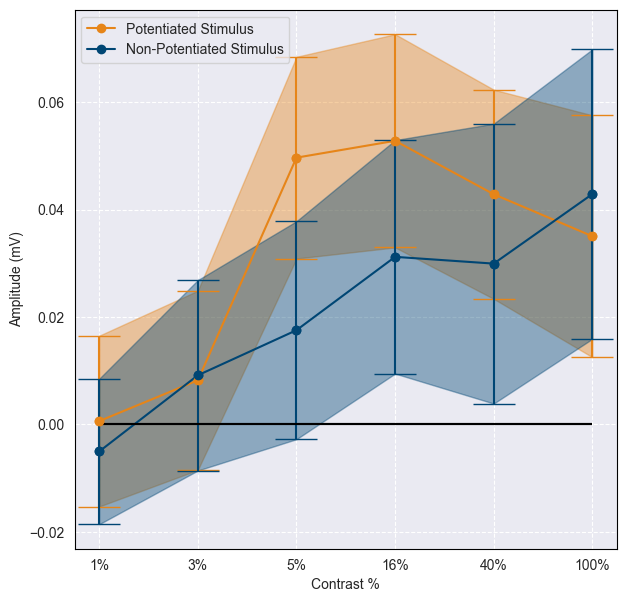

In [26]:
### plot mean response
pot_color_set = [13,4]
fig,axs = plt.subplots(figsize = ((7,7)))
Pot_Labels = ['Potentiated Stimulus','Non-Potentiated Stimulus']
for i in range(2):
    axs.plot(np.arange(0,6,1), Pot_DataSet_Avg[i],color = fill[pot_color_set[i]],marker = 'o', label = Pot_Labels[i])
    axs.errorbar(np.arange(0,6,1),Pot_DataSet_Avg[i], yerr = Pot_DataSet_Std[i], fmt = 'o',color = fill[pot_color_set[i]], barsabove= False , capsize=15)

    axs.fill_between(np.arange(0,6,1), Pot_DataSet_Avg[i] - Pot_DataSet_Std[i], Pot_DataSet_Avg[i] + Pot_DataSet_Std[i], color=fill[pot_color_set[i]], alpha=0.4)

    axs.legend()
    axs.set_ylabel(f'Amplitude (mV)')
    axs.set_xlabel(f'Contrast %')
    axs.set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
    axs.hlines(0,xmin = 0,xmax = 5, color = 'black')

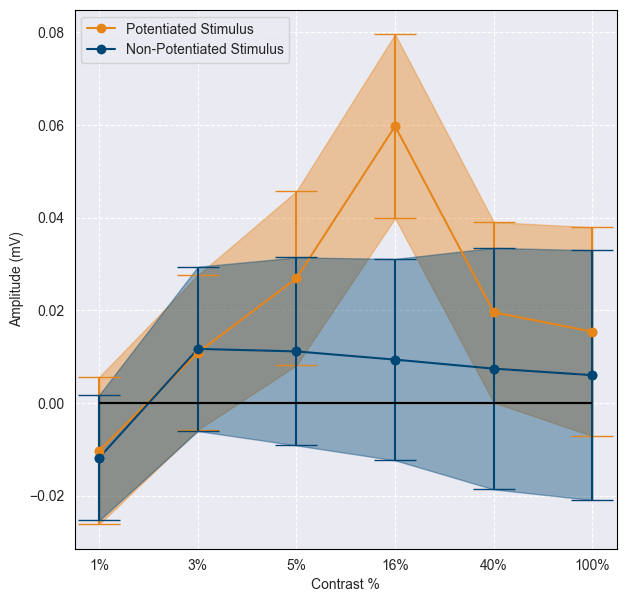

In [27]:
#### plot median response
pot_color_set = [13,4]
fig,axs = plt.subplots(figsize = ((7,7)))
Pot_Labels = ['Potentiated Stimulus','Non-Potentiated Stimulus']
for i in range(2):
    axs.plot(np.arange(0,6,1), Pot_DataSet_Med[i],color = fill[pot_color_set[i]],marker = 'o', label = Pot_Labels[i])
    axs.errorbar(np.arange(0,6,1),Pot_DataSet_Med[i], yerr = Pot_DataSet_Std[i], fmt = 'o',color = fill[pot_color_set[i]], barsabove= False , capsize=15)

    axs.fill_between(np.arange(0,6,1), Pot_DataSet_Med[i] - Pot_DataSet_Std[i], Pot_DataSet_Med[i] + Pot_DataSet_Std[i], color=fill[pot_color_set[i]], alpha=0.4)

    axs.legend()
    axs.set_ylabel(f'Amplitude (mV)')
    axs.set_xlabel(f'Contrast %')
    axs.set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
    axs.hlines(0,xmin = 0,xmax = 5, color = 'black')

#### Plot all responses along same graph and also solo

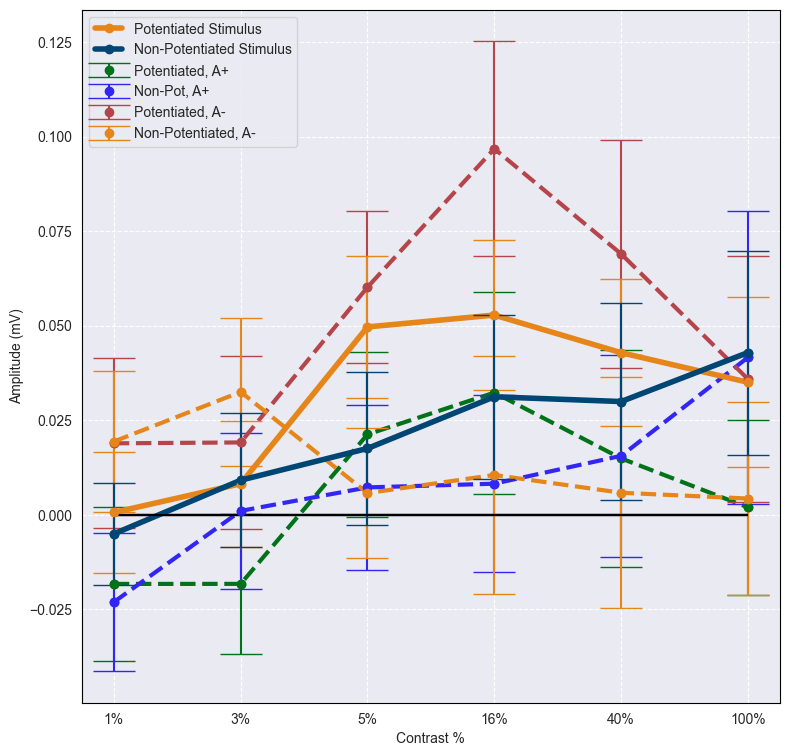

In [28]:
fig,axs = plt.subplots(figsize = ((9,9)))

for i in range(4):
    axs.plot(np.arange(0,6,1), AvgCondX[i],color = fill[color_set[i]],marker = 'o', linewidth = 3,linestyle='--')
    axs.errorbar(np.arange(0,6,1),AvgCondX[i], yerr = CondX_ErrorBars[i], fmt = 'o',label = Condition_Label[i],color = fill[color_set[i]], barsabove= False , capsize=15, markersize=6 )

    #axs.fill_between(np.arange(0,6,1), AvgCondX[i] - CondX_ErrorBars[i], AvgCondX[i] + CondX_ErrorBars[i], color=fill[color_set[i]], alpha=0.4)

    axs.legend()
    axs.set_ylabel(f'Amplitude (mV)')
    axs.set_xlabel(f'Contrast %')
    axs.set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
    axs.hlines(0,xmin = 0,xmax = 5, color = 'black')

for i in range(2):
    axs.plot(np.arange(0,6,1), Pot_DataSet_Avg[i],color = fill[pot_color_set[i]],marker = 'o', label = Pot_Labels[i], linewidth = 4)
    axs.errorbar(np.arange(0,6,1),Pot_DataSet_Avg[i], yerr = Pot_DataSet_Std[i], fmt = 'o',color = fill[pot_color_set[i]], barsabove= False , capsize=15)

    #axs.fill_between(np.arange(0,6,1), Pot_DataSet_Avg[i] - Pot_DataSet_Std[i], Pot_DataSet_Avg[i] + Pot_DataSet_Std[i], color=fill[pot_color_set[i]], alpha=0.4)

    axs.legend()
    axs.set_ylabel(f'Amplitude (mV)')
    axs.set_xlabel(f'Contrast %')
    axs.set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
    axs.hlines(0,xmin = 0,xmax = 5, color = 'black')

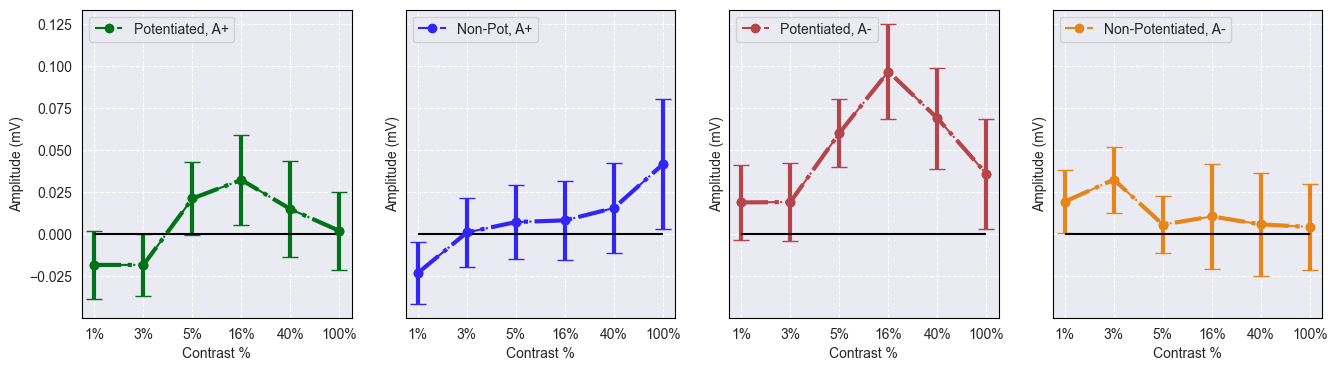

In [29]:
fig,axs = plt.subplots(1,4,figsize = (16,4),sharey= True, squeeze=True)

for sn in  range(4):
    axs[sn].plot(AvgCondX[sn], color = fill[color_set[sn]],label = Condition_Label[sn],linestyle='-.', marker='o',)
    axs[sn].errorbar(x = np.arange(0,6,1),y = AvgCondX[sn], yerr = CondX_ErrorBars[sn], color = fill[color_set[sn]], capsize=6, linewidth = 3,linestyle='-.', marker='o', markersize=6)
    axs[sn].legend(loc = 'upper left')
    axs[sn].hlines(0,xmin = 0,xmax = 5, color = 'black')
    axs[sn].set_ylabel(f'Amplitude (mV)')
    axs[sn].set_xlabel(f'Contrast %')
    axs[sn].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)

#### Plot Normalized CRF pre/post for all participants 

In [30]:
# Harmonic2plot = 1 # 2nd harmonic
# # plot 2nd harmonic for : *Potentiated, A+* *Non-Pot, A+* *Potentiated, A-* *Non-Potentiated, A-*
# Condition_Label = ['Potentiated, A+', 'Non-Pot, A+', 'Potentiated, A-', 'Non-Potentiated, A-']
# FigDir = 'C:\\plimon\\LTP_analysis\\RCA_Fx_OutputData\\Normalized_CRF_Responses\\Figures\\ExptGroup\\'
# if not os.path.exists(FigDir):
#     os.makedrs(FigDir)
# for TotSubs in range(len(CRF_IndividualResponses_Sorted)):
#     fig, axs = plt.subplots(1,4, figsize = ((13,4)), sharey = True)

#     Subj_Title = Subj_Ids[TotSubs]

#     CRF_Import = CRF_IndividualResponses_Sorted[TotSubs]
#     Diff_Import = PostInduction_IndividualResponses_Sorted[TotSubs]

#     for CondX in range(4):
#         CoData = np.array(CRF_Import[CondX][Harmonic2plot,:,:])
#         axs[CondX].plot(CoData[0,:], label = 'pre', color = fill[0],linestyle='-.', marker='o', markersize=5)
#         axs[CondX].plot(CoData[1,:], label = 'post', color = fill[12],linestyle='-.', marker='o', markersize=5)
#         axs[CondX].hlines(0,xmin = 0,xmax = 5, color = fill[0])

#         axs[CondX].plot(Diff_Import[CondX][Harmonic2plot,:], label = 'Post - Pre', color = fill[3], linestyle='-.', marker='o', markersize=5)

#         axs[CondX].set_title(Condition_Label[CondX])
#         axs[CondX].legend(loc = 'upper left')

#     fig.suptitle(f'4F CRF Responses for Participant: {Subj_Title}')

#     FigOutPath = os.path.join(FigDir, f'4F_CRF_Responses_Participant_{Subj_Title}.png')
#     plt.savefig(FigOutPath)
#     plt.close(fig)

#### Export response changes and stds for visualization

In [31]:
#### Export CRF DIfference Values and STD
ExportData = {} 

ExportData['NetResponseChange'] = AvgCondX 
ExportData['STD_ResponseChange'] = CondX_ErrorBars
#ExportData['NetResponseChange'] = Potentiation_DataSet # F1 and F2 respectively 

In [32]:
# DataOutDir= 'C:\\plimon\\SSRP_analysis_branch\\NetResponseChange_postInduction\\'
# os.chdir(DataOutDir)

# dnt = datetime.now() # add date and time bc im wreckless when saving ..
# fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...

# matFileN = f'{FileOutName}_{fdnt}.mat' 
# pklFileN = f'{FileOutName}_{fdnt}.pkl'

# matPath = os.path.join(DataOutDir ,matFileN )
# pklPath = os.path.join(DataOutDir ,pklFileN )

# scipy.io.savemat(matPath, ExportData)

# with open(pklPath, 'wb') as file:
#     pkl.dump(ExportData, file)

##### *Set ANOVA Dataframe Export Values of Interest*

In [33]:
Harmonic_Range_To_Include = np.arange(0,1)#np.arange(0,2) # 2f - 8f 
print(f'Harmonics to be exported: {Harmonic_Range_To_Include+1} F')
NumPrePost = 2
NumBins = 6
HI = [0,1,0,1]
AXI = [0,0,1,1]

Harmonics to be exported: [1] F


### *ANOVA Dataframe Section - Stores Pre and Post Data in 3 Different manners*

#### *Function #1 for making dataframes - Pre and Post on same column*

In [34]:
# def Init_DataFramesPerSubj(Harmonic_Range_To_Include,NumPrePost,NumBins,HemiInd,AttnXInd,dfIn, CoIn,SubjIDIn):
#     """Make dataframes for each particpant.
#     Harmonic_Range_To_Include = np.arange(0,4) = 2F,4F,6F,8F
#     NumPrePost = 2 pre post
#     NumBins = 6 (contrast sweeps)
#     HemiInd = F1 or F2 (binary array)
#     AttnXInd = attn + , attn - (binary array)
#     dfIn = data frame in
#     CoIn = condition for iterating 
#     SubjIDIn = subject ID 
#     """
#     df_Exports = [] # string for Data frames per subj
#     for subjResponses in range((len(dfIn))):
#         SubjName_Col = SubjIDIn[subjResponses]
#         dataFr_In = dfIn[subjResponses][CoIn][Harmonic_Range_To_Include,:] # [2 x 2 x 6]
#         [h,pp,b] = np.shape(dataFr_In) # harmonic , pre post , contrast
#         GenerateRows = h*pp*b
#         Reps = int((GenerateRows/NumBins))
#         DataFrame_Out = np.zeros((GenerateRows,7))
#         DataFrame_Out[:,0] = np.tile(SubjName_Col, GenerateRows) # subject label as 0th col
#         DataFrame_Out[:,1] = [val for val in Harmonic_Range_To_Include for _ in range(NumBins*NumPrePost)] # harmonic index
#         DataFrame_Out[:,2] = np.tile([0,1], int(GenerateRows/2)) # pre post labels! 0 == Pre, 1 == Post
#         DataFrame_Out[:,3] = np.tile([0,0,1,1,2,2,3,3,4,4,5,5],int(Reps/2)) # contrast values 
#         DataFrame_Out[:,4] = np.tile(int(HemiInd), GenerateRows)
#         DataFrame_Out[:,5] = np.tile(int(AttnXInd), GenerateRows)
#         for i in range(len(Harmonic_Range_To_Include)):
#             s = (i*NumBins)*2
#             DataFrame_Out[s:s+12,6] = np.ravel(np.column_stack(dataFr_In[i,:])) 
#         #df = pd.DataFrame(DataFrame_Out)#, columns=['SubjLabel', 'Harmonic', 'PrePost', 'Contrast','Hemifield','Attend2' 'Value'])
#         # df_Exports.append(df)
#         #DataFrame_Out = np.nan_to_num(DataFrame_Out, nan = -999)
#         DataFrame_Out = DataFrame_Out.astype(np.float64)
#         df_Exports.append(DataFrame_Out)
#     return df_Exports
# dFrames_Out = {}

# for Condition_DF_Exports in range(4):

#     dFrames_Out[Condition_DF_Exports] = Init_DataFramesPerSubj(Harmonic_Range_To_Include,NumPrePost,NumBins,HemiInd = HI[Condition_DF_Exports],AttnXInd = AXI[Condition_DF_Exports],dfIn = CRF_IndividualResponses_Sorted, CoIn = Condition_DF_Exports,SubjIDIn = Subj_Ids)
#     print(len(dFrames_Out[Condition_DF_Exports]))
# print(dFrames_Out[0][0][0,:])
# print()
# print(dFrames_Out[3][0][-1,:])
# print(len(dFrames_Out[0]))

# print(dFrames_Out[0][0].shape) # rows x columns (conitions of expt. params)
# print(dFrames_Out[0][0][:,0])  # subject ID
# print(dFrames_Out[0][0][:,1])  # hamronic index
# print(dFrames_Out[0][0][:,2])  # pre post 
# print(dFrames_Out[0][0][:,3])
# print(dFrames_Out[0][0][:,4])
# print(dFrames_Out[0][0][:,5])
# print(dFrames_Out[0][0][:,6])
# headers = ['sID','Harmonic','PrePost','Contrast','Hemifield','AttnTowards','Vals']
# temp_df_storage = {}

# for CombineFrames in range(4):
#     temp_df_storage[CombineFrames] = np.concatenate(dFrames_Out[CombineFrames])

# arr2list = list(temp_df_storage.values()) # turn array into a list
# CombineAllDataFrames = np.concatenate(arr2list,axis = 0) # to concatenate the 4 conditon data frames into 1
# Add_Headers_2_DF = pd.DataFrame(CombineAllDataFrames, columns = headers) # add headers to mat

# print(Add_Headers_2_DF['Contrast'][0:12]) # sanity check
# print(f'All Data including NaNs: {Add_Headers_2_DF.shape}') # get shape
# No_Nans_inDataFrame = Add_Headers_2_DF.dropna(subset=[Add_Headers_2_DF.columns[-1]]) # drop nans from missing files
# print(No_Nans_inDataFrame['Contrast'][0:12])
# print(f'All Data after NaN data is removed: {No_Nans_inDataFrame.shape}')

# d_frameOut = No_Nans_inDataFrame.astype(np.float64)
# print(d_frameOut.shape)

# FramesOut = {'CRF_Difference_Values': d_frameOut,
#              'Headers': headers}
# DataOutDir= 'C:\\plimon\\SSRP_analysis_branch\\Subj_Dataframes\\'
# os.chdir(DataOutDir)
# print(dFrames_Out[0][0][0,:])
# print()
# print(dFrames_Out[3][0][-1,:])

# headers = ['sID','Harmonic','PrePost','Contrast','Hemifield','AttnTowards','Vals']
# temp_df_storage = {}

# for CombineFrames in range(4):
#     temp_df_storage[CombineFrames] = np.concatenate(dFrames_Out[CombineFrames])

# arr2list = list(temp_df_storage.values()) # turn array into a list
# CombineAllDataFrames = np.concatenate(arr2list,axis = 0) # to concatenate the 4 conditon data frames into 1
# Add_Headers_2_DF = pd.DataFrame(CombineAllDataFrames, columns = headers) # add headers to mat

# print(Add_Headers_2_DF['Contrast'][0:12]) # sanity check
# print(f'All Data including NaNs: {Add_Headers_2_DF.shape}') # get shape
# No_Nans_inDataFrame = Add_Headers_2_DF.dropna(subset=[Add_Headers_2_DF.columns[-1]]) # drop nans from missing files
# print(No_Nans_inDataFrame['Contrast'][0:12])
# print(f'All Data after NaN data is removed: {No_Nans_inDataFrame.shape}')

# d_frameOut = No_Nans_inDataFrame.astype(np.float64)
# print(d_frameOut.shape)

# FramesOut = {'CRF_Difference_Values': d_frameOut,
#              'Headers': headers}
# DataOutDir= 'C:\\plimon\\SSRP_analysis_branch\\Subj_Dataframes\\'
# os.chdir(DataOutDir)

#### *Function #2 for making dataframes. Pre Post values are in different columns, not along 1 column*

In [35]:
print(f'Making Dataframe for Harmonics: {Harmonic_Range_To_Include+1} ONLY')

Making Dataframe for Harmonics: [1] ONLY


In [36]:
def Init_DataFramesPerSubj_wPrePostCols(Harmonic_Range_To_Include,NumBins,HemiInd,AttnXInd,dfIn, CoIn,SubjIDIn):
    """Make dataframes for each particpant.
    Harmonic_Range_To_Include = np.arange(0,4) = 2F,4F,6F,8F
    NumPrePost = 2 pre post
    NumBins = 6 (contrast sweeps)
    HemiInd = F1 or F2 (binary array)
    AttnXInd = attn + , attn - (binary array)
    dfIn = data frame in
    CoIn = condition for iterating 
    SubjIDIn = subject ID """
    df_Exports = [] # strinf for Data frames per subj
    for subjResponses in range((len(dfIn))):
        SubjName_Col = SubjIDIn[subjResponses] # enter single subj ID 
        dataFr_In = dfIn[subjResponses][CoIn][Harmonic_Range_To_Include,:] # [2 x 2 x 6] response data

        [h,pp,b] = np.shape(dataFr_In) # harmonic , pre post , contrast
        GenerateRows = int ( ( h * pp * b ) / 2 ) # prepost no longer stacked - new col for each

        Reps = int((GenerateRows/NumBins)) # 2 ... for what tho ...
        DataFrame_Out = np.zeros((GenerateRows,7)) # 12 x 7 df for 1 subject 

        DataFrame_Out[:,0] = np.tile(SubjName_Col, GenerateRows) # subject label as 0th col
        DataFrame_Out[:,1] = [val for val in Harmonic_Range_To_Include for _ in range(NumBins)] # harmonic index
        # DataFrame_Out[:,2] = np.tile([0,1], int(GenerateRows/2)) # pre post labels! 0 == Pre, 1 == Post
        DataFrame_Out[:,2] = np.tile([0,1,2,3,4,5],int(Reps)) # contrast values 
        DataFrame_Out[:,3] = np.tile(int(HemiInd), GenerateRows) # hemfield index
        DataFrame_Out[:,4] = np.tile(int(AttnXInd), GenerateRows) # attned towards index
        preVals = dataFr_In[:,0,:] # isolate pre data imported
        DataFrame_Out[:,5] = preVals.reshape(-1) # pre crf values !!!!!
        postVals = dataFr_In[:,1,:] # isolate pre data imported
        DataFrame_Out[:,6] = postVals.reshape(-1) # post crf values!!!!!!!!
        # for i in range(len(Harmonic_Range_To_Include)):
        #     s = (i*NumBins)*2
        #     DataFrame_Out[s:s+12,6] = np.ravel(np.column_stack(dataFr_In[i,:])) 
        DataFrame_Out = DataFrame_Out.astype(np.float64)
        df_Exports.append(DataFrame_Out)

    return df_Exports

In [37]:
dFrames_Out_prepost = {}
for Condition_DF_Exports in range(4):

    dFrames_Out_prepost[Condition_DF_Exports] = Init_DataFramesPerSubj_wPrePostCols(Harmonic_Range_To_Include,NumBins,HemiInd = HI[Condition_DF_Exports],AttnXInd = AXI[Condition_DF_Exports],dfIn = CRF_IndividualResponses_Sorted, CoIn = Condition_DF_Exports,SubjIDIn = Subj_Ids)
    print(len(dFrames_Out_prepost[Condition_DF_Exports]))

38
38
38
38


#### Sanity Check 

In [38]:
headers = ['sID','Harmonic','Contrast','Hemifield','AttnTowards','pre_crfVals', 'post_crfVals']
print(headers)

['sID', 'Harmonic', 'Contrast', 'Hemifield', 'AttnTowards', 'pre_crfVals', 'post_crfVals']


In [39]:
print(len(CRF_IndividualResponses_Sorted[0]))
print(CRF_IndividualResponses_Sorted[0][0].shape)
harmonicCheck = CRF_IndividualResponses_Sorted[0][0]
print(harmonicCheck[1,0,:])
print()
print(harmonicCheck[1,1,:])

4
(4, 2, 6)
[0.12872096 0.26394827 0.50096303 0.81835711 0.91694411 1.        ]

[0.05271195 0.28508129 0.54620261 0.73621506 0.80660264 0.84919053]


In [40]:
print(dFrames_Out_prepost[0][0].shape) # rows x columns (conitions of expt. params)
print(dFrames_Out_prepost[0][0][:,0])  # subject ID
print(dFrames_Out_prepost[0][0][:,1])  # harmonic index
print(dFrames_Out_prepost[0][0][:,2])  # contrast values 
print(dFrames_Out_prepost[0][0][:,3])  # hemifield index
print(dFrames_Out_prepost[0][0][:,4])  # attnwtion towards index
print(dFrames_Out_prepost[0][0][:,5])  # pre-induction crf values 
print(dFrames_Out_prepost[0][0][:,6])  # post-induction crf values

(6, 7)
[2651. 2651. 2651. 2651. 2651. 2651.]
[0. 0. 0. 0. 0. 0.]
[0. 1. 2. 3. 4. 5.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.13062946 0.35761936 0.59469191 0.85157679 1.         0.83510569]
[0.11658603 0.28832397 0.57315865 0.78989264 0.92931891 0.77712696]


In [41]:
print(len(dFrames_Out_prepost[0]))
print(len(GoodSubjs))
print(np.unique(GoodSubjs,return_counts = True))

38
38
(array([0., 1.]), array([ 5, 33], dtype=int64))


In [42]:
temp_df_storage = {}
for CombineFrames in range(4):
    GoodSubjMats = [dFrames_Out_prepost[CombineFrames][i] for i in range(len(GoodSubjs)) if GoodSubjs[i] == 1]
    print(len(GoodSubjMats))
    temp_df_storage[CombineFrames] = np.concatenate(GoodSubjMats,axis = 0)

33
33
33
33


In [44]:
print(len(dFrames_Out_prepost[0]))
print(dFrames_Out_prepost[0][0].shape)
print(temp_df_storage[0].shape)

38
(6, 7)
(198, 7)


In [45]:
arr2list = list(temp_df_storage.values()) # turn array into a list
CombineAllDataFrames = np.concatenate(arr2list,axis = 0) # concatenate the 4 conditon data frames into 1
Add_Headers_2_DF = pd.DataFrame(CombineAllDataFrames, columns = headers) # add headers to mat

#### *Table for visual inspection*

In [46]:
Add_Headers_2_DF

,sID,Harmonic,Contrast,Hemifield,AttnTowards,pre_crfVals,post_crfVals
0,2651.0,0.0,0.0,0.0,0.0,0.130629,0.116586
1,2651.0,0.0,1.0,0.0,0.0,0.357619,0.288324
2,2651.0,0.0,2.0,0.0,0.0,0.594692,0.573159
3,2651.0,0.0,3.0,0.0,0.0,0.851577,0.789893
4,2651.0,0.0,4.0,0.0,0.0,1.000000,0.929319
...,...,...,...,...,...,...,...
787,345216.0,0.0,1.0,1.0,1.0,0.370800,0.522512
788,345216.0,0.0,2.0,1.0,1.0,0.583180,0.635701
789,345216.0,0.0,3.0,1.0,1.0,0.648800,0.763474
790,345216.0,0.0,4.0,1.0,1.0,0.748285,0.823584


In [47]:
print(Add_Headers_2_DF['Contrast'][0:12]) # sanity check
print(f'All Data including NaNs: {Add_Headers_2_DF.shape}') # get shape
No_Nans_inDataFrame = Add_Headers_2_DF.dropna(subset=[Add_Headers_2_DF.columns[-1]]) # drop nans from missing files
print(No_Nans_inDataFrame['Contrast'][0:12])
print(f'All Data after NaN data is removed: {No_Nans_inDataFrame.shape}')

0     0.0
1     1.0
2     2.0
3     3.0
4     4.0
5     5.0
6     0.0
7     1.0
8     2.0
9     3.0
10    4.0
11    5.0
Name: Contrast, dtype: float64
All Data including NaNs: (792, 7)
0     0.0
1     1.0
2     2.0
3     3.0
4     4.0
5     5.0
6     0.0
7     1.0
8     2.0
9     3.0
10    4.0
11    5.0
Name: Contrast, dtype: float64
All Data after NaN data is removed: (660, 7)


In [48]:
print(FileOutName)

Subject_ANOVA_DF_ExptGroup_RCA1_2F_HarmonicOnly_STD_3_5


In [49]:
d_frameOut = No_Nans_inDataFrame.astype(np.float64)
print(d_frameOut.shape)

FramesOut = {'CRF_Difference_Values': d_frameOut,
             'Headers': headers}
DataOutDir= 'C:\\plimon\\SSRP_analysis_branch\\Subj_Dataframes\\'
os.chdir(DataOutDir)

dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.mat' 
print(FileN)

scipy.io.savemat(FileN, FramesOut)

(660, 7)
Subject_ANOVA_DF_ExptGroup_RCA1_2F_HarmonicOnly_STD_3_5_20240717_142947.mat


#### *Function #3 for making dataframes. Pre Post values subtracted, in along same column*


In [ ]:
# def Init_ResponseDifferences_DataFramesPerSubj(Harmonic_Range_To_Include,NumBins,HemiInd,AttnXInd,dfIn, CoIn,SubjIDIn):
#     df_Exports = [] # strinf for Data frames per subj
#     for subjResponses in range((len(dfIn))):
#         SubjName_Col = SubjIDIn[subjResponses] # enter single subj ID   
#         dataFr_In = np.array(dfIn[subjResponses][CoIn][Harmonic_Range_To_Include,:]) # [2 x 2 x 6] response data
#         [HamronicDiffs , sweepVals] = dataFr_In.shape # hamronic indicies x bins 

#         GenerateRows = int ( HamronicDiffs * sweepVals) # prepost no longer stacked - new col for each

#         Reps = int((GenerateRows/NumBins)) # 2 ... for what tho ...
#         DataFrame_Out = np.zeros((GenerateRows,6)) # 12 x 6 df for 1 subject 

#         DataFrame_Out[:,0] = np.tile(SubjName_Col, GenerateRows) # subject label as 0th col
#         DataFrame_Out[:,1] = [val for val in Harmonic_Range_To_Include for _ in range(NumBins)] # harmonic index

#         DataFrame_Out[:,2] = np.tile([0,1,2,3,4,5],int(Reps)) # contrast values 
#         DataFrame_Out[:,3] = np.tile(int(HemiInd), GenerateRows) # hemfield index

#         DataFrame_Out[:,4] = np.tile(int(AttnXInd), GenerateRows) # attned towards index

#         DiffDataSorted = dataFr_In.reshape(1,-1)
#         DataFrame_Out[:,5] = DiffDataSorted # response differences post - pre

#         DataFrame_Out = DataFrame_Out.astype(np.float64)
#         df_Exports.append(DataFrame_Out)

#     return df_Exports
    
# dFrames_Out_diffs = {}
# for Condition_DF_Exports in range(4):
#     dFrames_Out_diffs[Condition_DF_Exports] = Init_ResponseDifferences_DataFramesPerSubj(Harmonic_Range_To_Include,NumBins,HemiInd = HI[Condition_DF_Exports],AttnXInd = AXI[Condition_DF_Exports],dfIn = PostInduction_IndividualResponses_Sorted, CoIn = Condition_DF_Exports,SubjIDIn = Subj_Ids)

# # sanity check 
# print(dFrames_Out_diffs[0][0][0,:])
# print()
# print(dFrames_Out_diffs[3][0][-1,:])


# headers = ['sID','Harmonic','Contrast','Hemifield','AttnTowards','Vals']
# temp_df_storage = {}

# for CombineFrames in range(4):
#     temp_df_storage[CombineFrames] = np.concatenate(dFrames_Out_diffs[CombineFrames])

# arr2list = list(temp_df_storage.values()) # turn array into a list
# CombineAllDataFrames = np.concatenate(arr2list,axis = 0) # to concatenate the 4 conditon data frames into 1
# Add_Headers_2_DF = pd.DataFrame(CombineAllDataFrames, columns = headers) # add headers to mat

# print(Add_Headers_2_DF['Contrast'][0:12]) # sanity check
# print(f'All Data including NaNs: {Add_Headers_2_DF.shape}') # get shape
# No_Nans_inDataFrame = Add_Headers_2_DF.dropna(subset=[Add_Headers_2_DF.columns[-1]]) # drop nans from missing files
# print(No_Nans_inDataFrame['Contrast'][0:12])
# print(f'All Data after NaN data is removed: {No_Nans_inDataFrame.shape}')

# d_frameOut = No_Nans_inDataFrame.astype(np.float64)
# print(d_frameOut.shape)

# FramesOut = {'CRF_Difference_Values_1DPVAR': d_frameOut, # post - pre (not long for repeated masures anova)
#              'Headers': headers}

# print(FileOutName)

# DataOutDir= 'C:\\plimon\\SSRP_analysis_branch\\Subj_Dataframes\\'
# os.chdir(DataOutDir)

# dnt = datetime.now() # add date and time bc im wreckless when saving ..
# fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
# matFileN = f'{FileOutName}_PostMinPre_As1DependentVar_{fdnt}.mat' 
# print(matFileN)
# scipy.io.savemat(matFileN, FramesOut)
# df = pd.DataFrame(FramesOut['CRF_Difference_Values_1DPVAR'])